<a href="https://colab.research.google.com/github/IngwarHighlander/Data-Analytics-Public/blob/main/Insights_into_the_company's_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TASK:
To clean and analyze data; find valuable insights into the company's operations.

In [ ]:
# Import od datasets and libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Colab_Notebooks/Mate_Academy
df_events = pd.read_csv("events.csv")
df_products = pd.read_csv("products.csv")
df_countries = pd.read_csv("countries.csv")

# Data overview
print(df_events.head())
print(df_products.head())
print(df_countries.head())
print(df_events.info())
print(df_products.info())
print(df_countries.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/Mate_Academy
    Order ID Order Date   Ship Date Order Priority Country Code  Product ID  \
0  100640618  10/8/2014  10/18/2014              M          NOR        2103   
1  100983083  8/11/2016   8/11/2016              C          SRB        2103   
2  101025998  7/18/2014   8/11/2014              M          NaN        7940   
3  102230632  5/13/2017   6/13/2017              L          MNE        2455   
4  103435266  8/11/2012   9/18/2012              H          SRB        1270   

  Sales Channel  Units Sold  Unit Price  Unit Cost  
0        Online       650.0      205.70     117.11  
1       Offline      1993.0      205.70     117.11  
2        Online      4693.0      668.27     502.54  
3        Online      1171.0      109.28      35.84  
4       Offline      7648.0       47.45      31.79  
     id        item_type
0

# Data overview

1. Main table — events.csv:
Містить дані про замовлення:

Contains order data:

- "Order ID": Unique order identifier
- "Order Date": Order date (needs to be converted to datetime)
- "Ship Date": Shipment date (needs to be converted to datetime)
- "Order Priority": Order priority
- "Country Code": Three-letter country code (ISO alpha-3)
- "Product ID": Product identifier
- "Sales Channel": Online or offline
- "Units Sold": Number of items sold
- "Unit Price": Unit price
- "Unit Cost": Unit cost

Key fields:
- "Product ID" joins dataset with products.csv
- "Country Code" joins with countries.csv

2. Product directory — products.csv:

- "id": matches "Product ID" in events.csv
- "item_type": Product category

3. Country directory — countries.csv:
- "alpha-3": ISO country code, matches "Country Code" from events.csv
- "name": Country name
- "region": Continent
- "sub-region": Sub-region

In [ ]:
# Need for data cleaning analysis
print(df_events.isnull().sum())
print(df_products.isnull().sum())
print(df_countries.isnull().sum())
print(df_events.duplicated().sum())
print(df_products.duplicated().sum())
print(df_countries.duplicated().sum())

Order ID           0
Order Date         0
Ship Date          0
Order Priority     0
Country Code      82
Product ID         0
Sales Channel      0
Units Sold         2
Unit Price         0
Unit Cost          0
dtype: int64
id           0
item_type    0
dtype: int64
name          0
alpha-2       1
alpha-3       0
region        1
sub-region    1
dtype: int64
0
0
0


#Data cleaning
##Missing values:

events.csv:
- "Country Code": 82 missing values ​​(since the rows may contain additional useful information and make up more than 6% of the total, we will not delete them)
- "Units Sold": 2 missing values ​​(since we do not know the reason for the missing data, it is better to delete these rows).

countries.csv:
1 missing value in "alpha-2", "region", "sub-region" — can be ignored, because the connection is made via "alpha-3".

##Data types:
"Order Date", "Ship Date" — must be converted to datetime. The remaining data types are correct.

##Duplicates
No duplicates found

##Other
The spelling "online" and "Online" was found in the "Sales Channel" column. Unification will be required.

In [ ]:
# Data cleaning
df_events["Country Code"] = df_events["Country Code"].replace(r'^\s*$', np.nan, regex=True)
df_events.dropna(subset=["Units Sold"], inplace=True)
df_events["Sales Channel"] = df_events["Sales Channel"].str.capitalize()
df_events["Order Date"] = pd.to_datetime(df_events["Order Date"], errors="coerce")
df_events["Ship Date"] = pd.to_datetime(df_events["Ship Date"], errors="coerce")

In [ ]:
# Merging datasets
df = df_events.merge(df_products, left_on="Product ID", right_on="id", how="left")
df = df.merge(df_countries, left_on="Country Code", right_on="alpha-3", how="left")


In [ ]:
# Basic metrics
df["Revenue"] = df["Units Sold"] * df["Unit Price"]
df["Cost"] = df["Units Sold"] * df["Unit Cost"]
df["Profit"] = df["Revenue"] - df["Cost"]
df_events["Shipping Delay"] = df_events["Ship Date"] - df_events["Order Date"]
average_delay = df_events["Shipping Delay"].mean()
online_share = df["Sales Channel"].value_counts(normalize=True).get("Online", 0)

print("Profit:", df["Profit"].sum())
print("Number of orders:", df["Order ID"].nunique())
print("Number of countries:", df["Country Code"].nunique())
print("Average shipping delay:", average_delay)
print("Online share:", online_share)


Profit: 501434459.0
Number of orders: 1328
Number of countries: 45
Average shipping delay: 24 days 18:53:07.951807229
Online share: 0.4992469879518072


# Key metrics

- Total revenue: 501434459.0
- Total orders: 1328
- Number of countries covered: 45
- Average shipping delay: approximately 24 days 19 hours
- Share of online sales: 49.92%


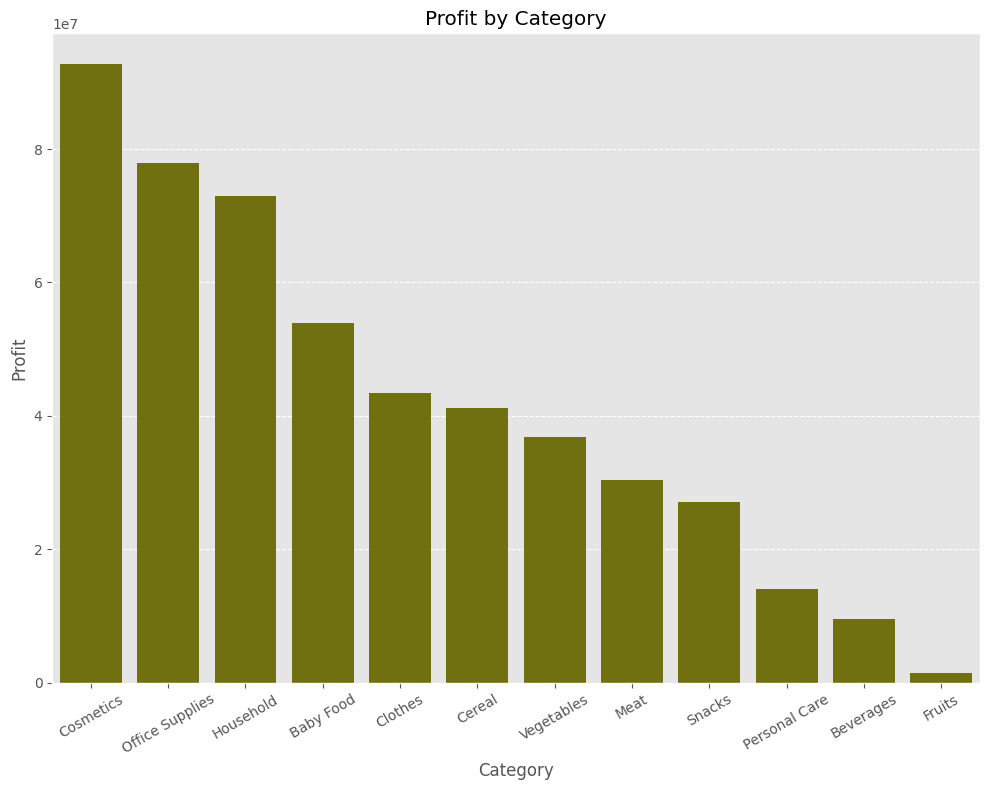

In [ ]:
# Visualisation

# Setting plot style
plt.style.use('ggplot')

# Plotting a bar chart: Profit by Category
plt.figure(figsize=(10, 8))
profit_by_category = df.groupby("item_type")["Profit"].sum().sort_values(ascending=False).reset_index()

sns.barplot(data=profit_by_category, x="item_type", y="Profit", estimator=sum, errorbar=("ci", False), color="olive")
plt.xlabel("Category")
plt.ylabel("Profit")
plt.title("Profit by Category")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


#Revenue by Category
The highest revenue generating categories are cosmetics, office supplies, household goods, baby food, clothing, and cereals. Personal care, beverages, and fruit are the lowest revenue generating categories and can be considered as substitutable by more profitable categories or new products.

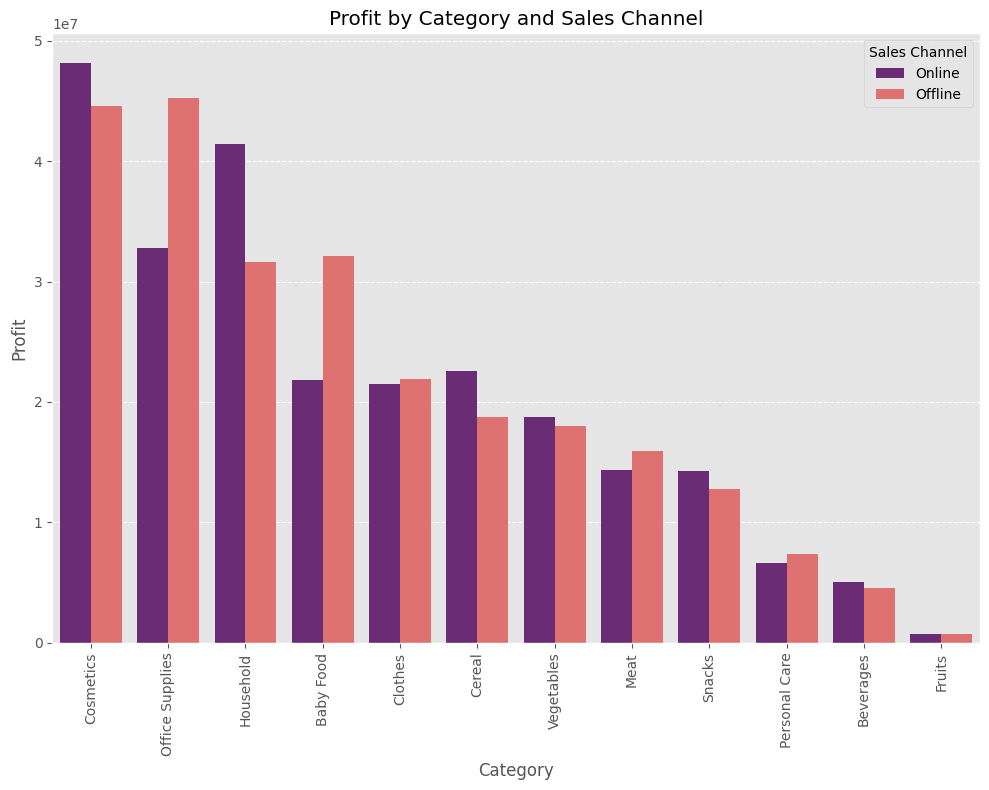

In [ ]:
# Plotting a bar chart: Profit by Category and Sales Channel
plt.figure(figsize=(10, 8))

sns.barplot(
    data=df,
    x="item_type",
    y="Profit", estimator=sum,
    errorbar=("ci", False),
    hue="Sales Channel",
    order=df.groupby("item_type")["Profit"].sum().sort_values(ascending=False).head(12).index,
    palette="magma")
plt.xlabel("Category")
plt.ylabel("Profit")
plt.title("Profit by Category and Sales Channel")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


#Sales Channels

Overall, there is no significant difference between online and offline sales, as costs remain the same and the sales channel volumes are quite comparable. In terms of individual categories, there is a noticeable advantage in online sales volumes for cosmetics and household goods, while offline sales prevail in the baby and office supplies categories.

<ipython-input-74-304e16028c1a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=profitability_by_category.values, y=profitability_by_category.index, palette="viridis")


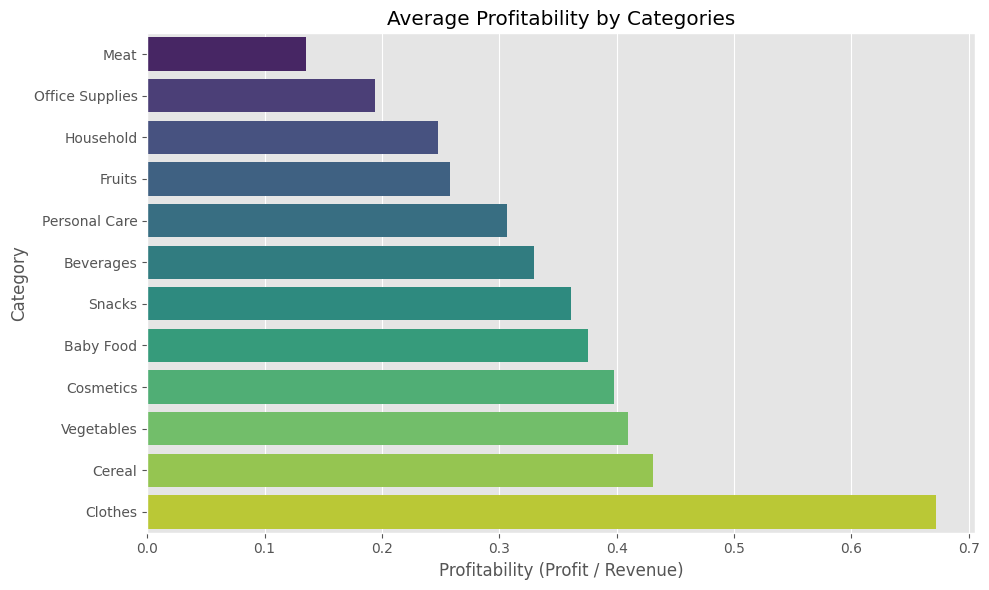

In [ ]:
#Plotting horizontal bar chart: Average Profitability by Categories
df["Profitability"] = df["Profit"] / df["Revenue"]

profitability_by_category = df.groupby("item_type")["Profitability"].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=profitability_by_category.values, y=profitability_by_category.index, palette="viridis")

plt.title("Average Profitability by Categories")
plt.xlabel("Profitability (Profit / Revenue)")
plt.ylabel("Category")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

#Profitability

Clothing provides the highest profitability (over 67%), but sales here are not at the highest level. Thus, it can be assumed that a more active marketing campaign could increase profit volumes in this category due to increased sales.

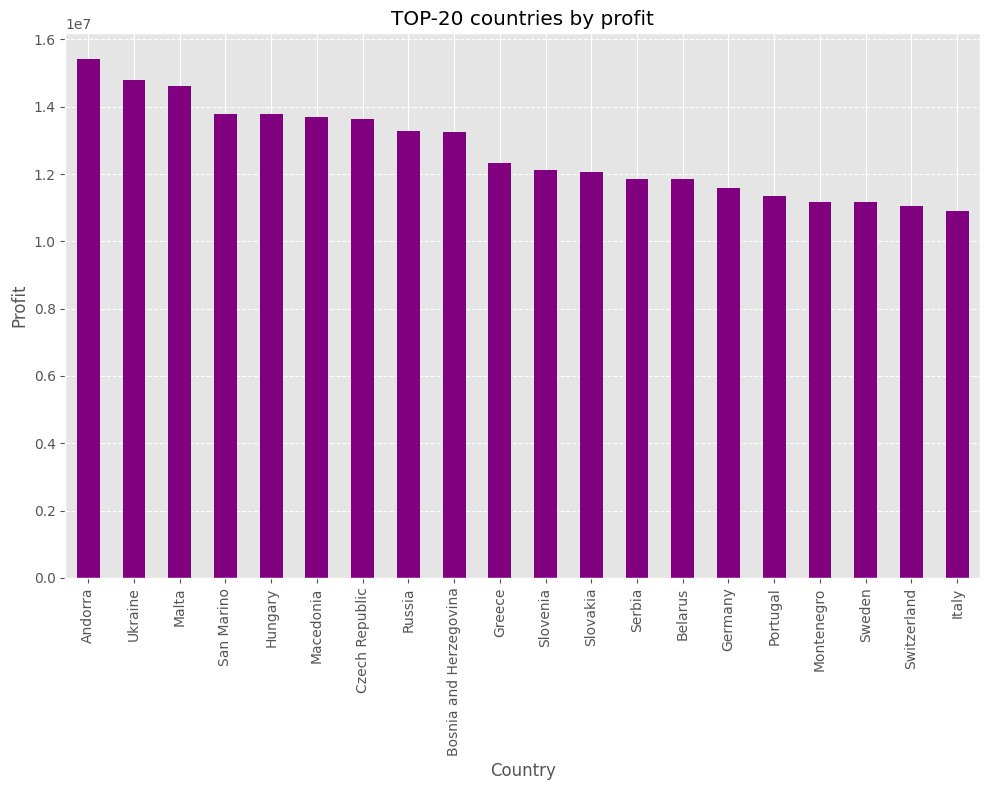

In [ ]:
# Plotting a bar chart: TOP-20 Countries by Profit
plt.figure(figsize=(10, 8))
country_profit = df.groupby("name")["Profit"].sum().sort_values(ascending=False).head(20)
country_profit.plot(kind="bar", color="purple")
plt.xlabel("Country")
plt.ylabel("Profit")
plt.title("TOP-20 countries by profit")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

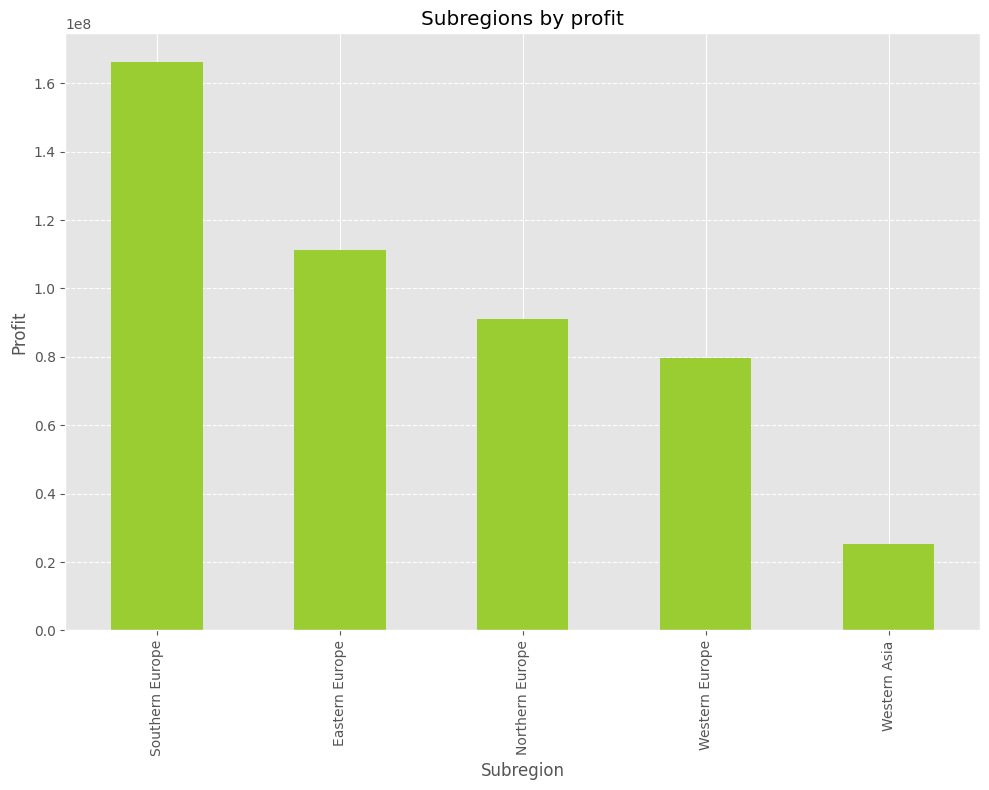

In [ ]:
# Plotting a bar chart: Subregions by Profit
plt.figure(figsize=(10, 8))
subregion_profit = df.groupby("sub-region")["Profit"].sum().sort_values(ascending=False).head(10)
subregion_profit.plot(kind="bar", color="yellowgreen")
plt.xlabel("Subregion")
plt.ylabel("Profit")
plt.title("Subregions by profit")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#Revenue by Country and Sub-Region

Sales are primarily in the European region, with the Southern European sub-region leading the revenue. Among the countries, Andorra, Ukraine, Malta and San Marino showed the highest revenue, which is also not typical given the size of the economies of some of these countries.

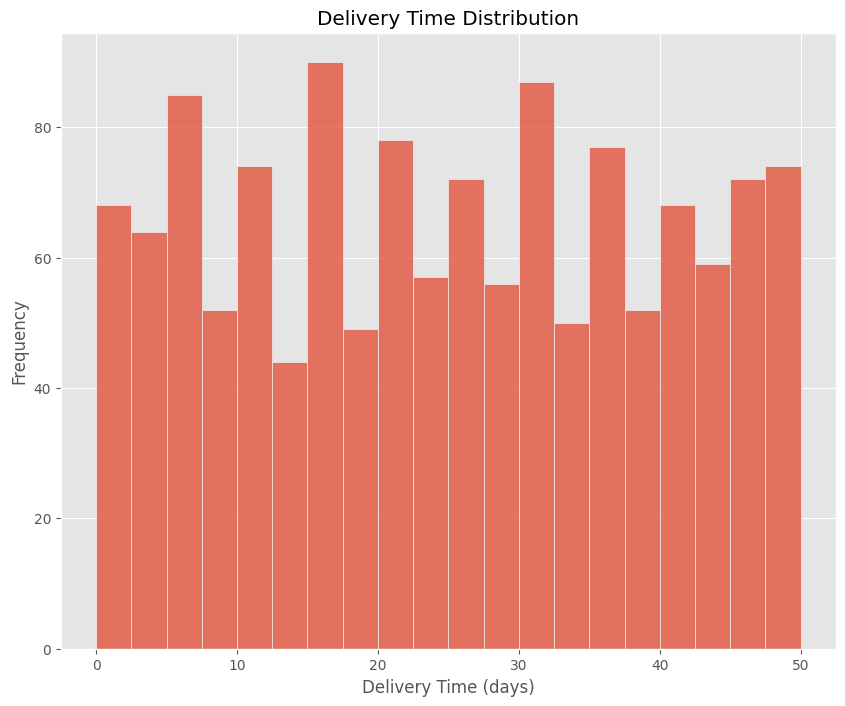

In [ ]:
# Plotting a histogram: Delivery Time
df["Delivery_Time"] = (df["Ship Date"] - df["Order Date"]).dt.days
plt.figure(figsize=(10, 8))
sns.histplot(df["Delivery_Time"], bins=20)
plt.title("Delivery Time Distribution")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.show()


<Figure size 800x1200 with 0 Axes>

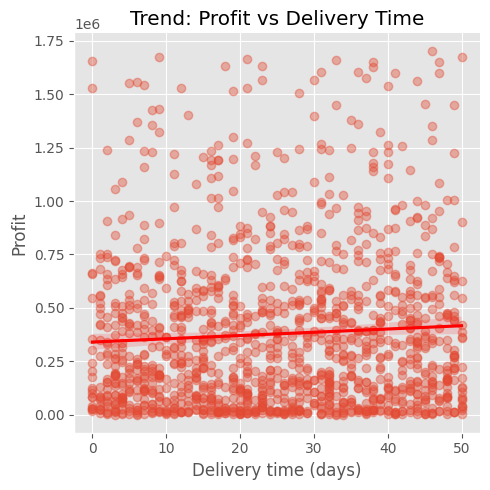

In [ ]:
#Scatter plot: Dependendence between delivery time and profit
plt.figure(figsize=(8, 12))
sns.lmplot(data=df, x="Delivery_Time", y="Profit", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Trend: Profit vs Delivery Time")
plt.xlabel("Delivery time (days)")
plt.ylabel("Profit")
plt.grid(True)
plt.tight_layout()
plt.show()



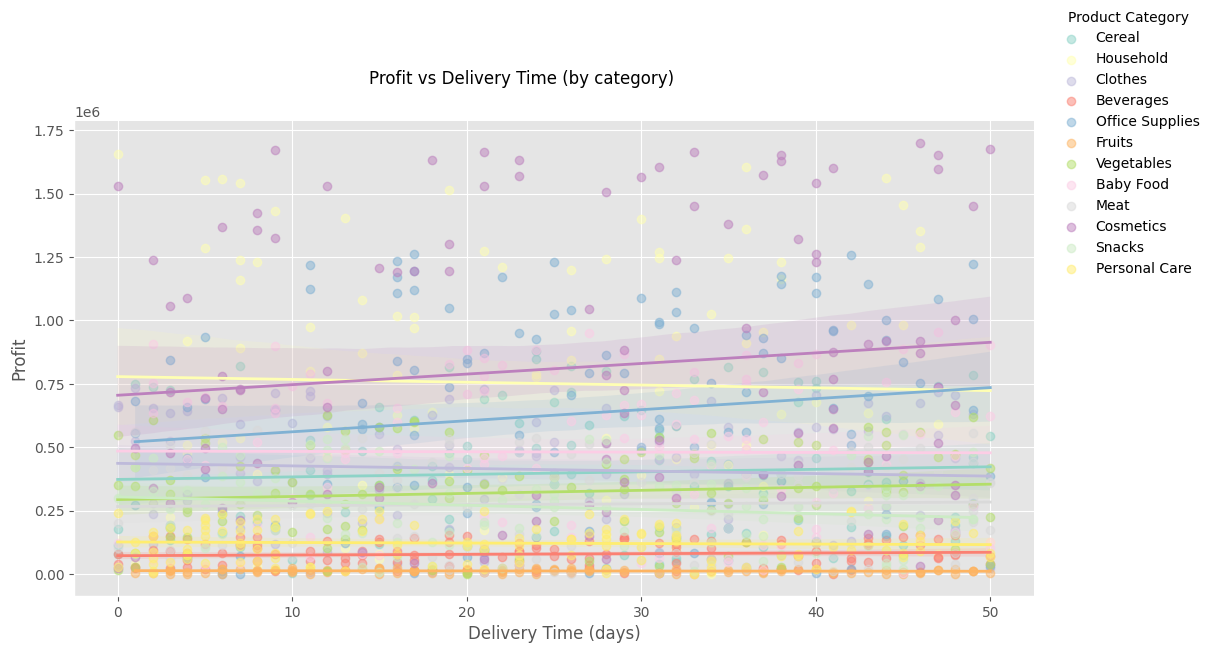

In [ ]:
#Scatter plot: Dependendence between delivery time and profit by categories
trend = sns.lmplot(
    data=df,
    x="Delivery_Time",
    y="Profit",
    hue="item_type",
    scatter_kws={'alpha': 0.5},
    line_kws={'linewidth': 2},
    height=6,
    aspect=1.5,
    palette="Set3"
)


trend.fig.suptitle("Profit vs Delivery Time (by category)")
trend.set_axis_labels("Delivery Time (days)", "Profit")

trend._legend.set_bbox_to_anchor((1.15, 0.85))
trend._legend.set_title("Product Category")

plt.grid(True)
plt.tight_layout()
plt.show()

# Dependence between profit and delivery time

Profit almost does not depend on the duration of delivery, including by separate categories of goods. Only in cosmetics is there a certain linear dependence of profit growth with increasing delivery time.

<ipython-input-133-542e00519674>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Delivery_Time", y="name", palette="Set3")


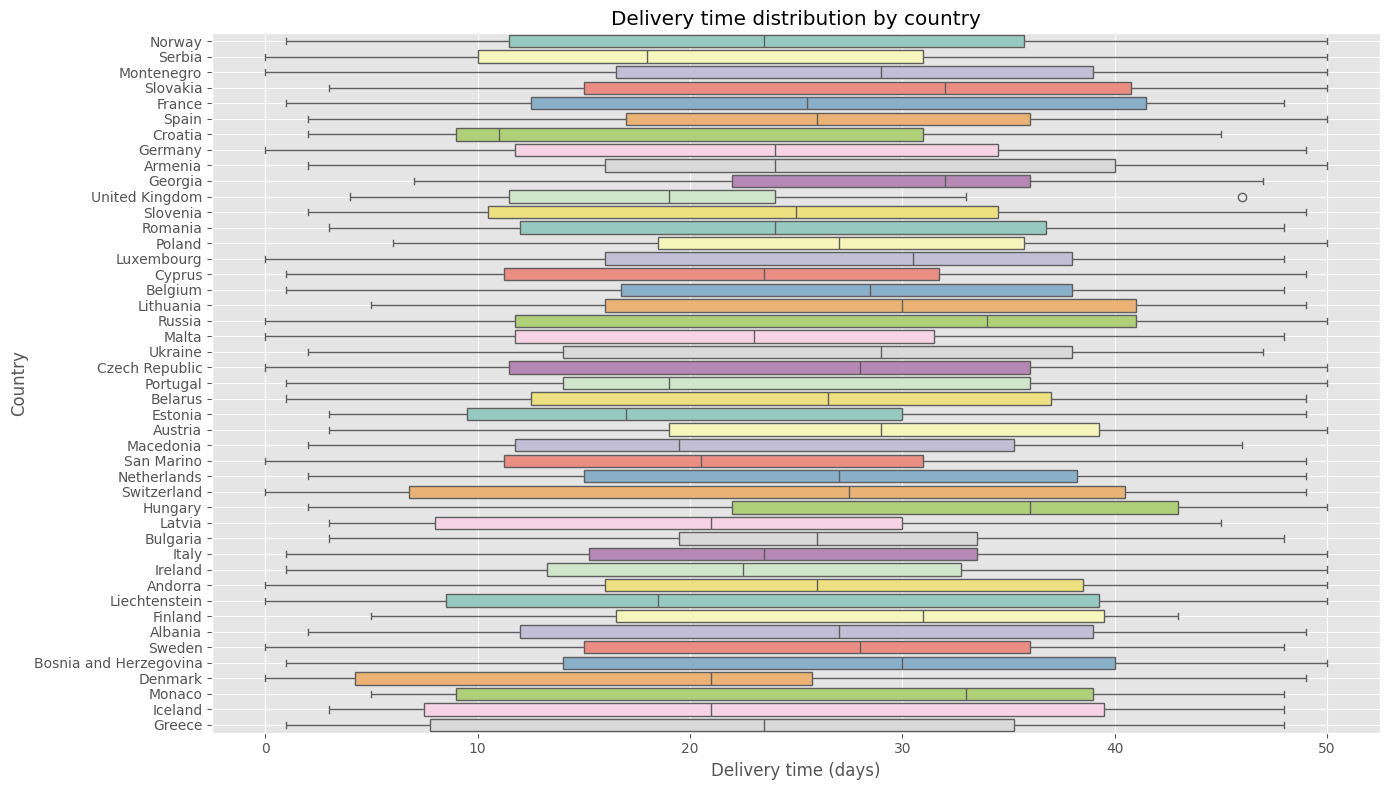

In [ ]:
# Boxplot: Delivery time distribution by country
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x="Delivery_Time", y="name", palette="Set3")
plt.title("Delivery time distribution by country")
plt.xlabel("Delivery time (days)")
plt.ylabel("Country")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-136-a743a8729154>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Delivery_Time", y="sub-region", palette="Set3")


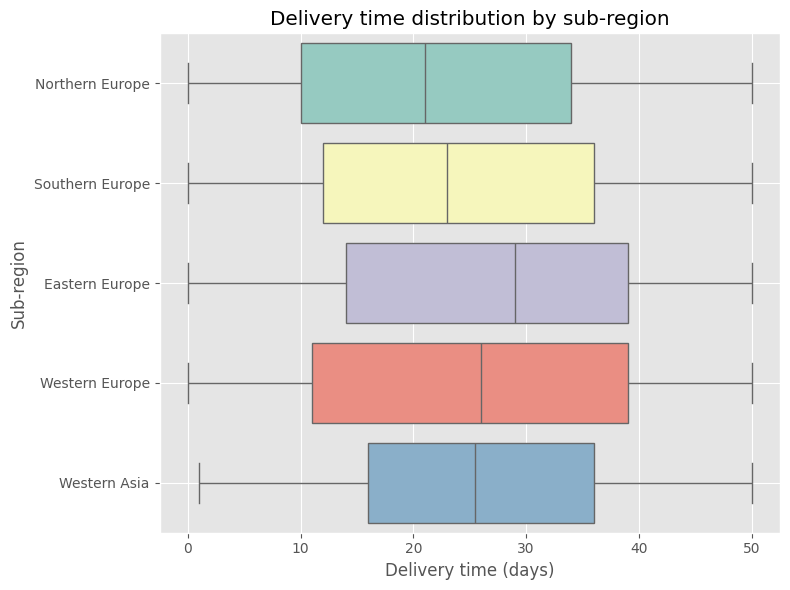

In [ ]:
# Boxplot: Delivery time distribution by sub-region
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Delivery_Time", y="sub-region", palette="Set3")
plt.title("Delivery time distribution by sub-region")
plt.xlabel("Delivery time (days)")
plt.ylabel("Sub-region")
plt.grid(True)
plt.tight_layout()
plt.show()

#Geographic dependence of delivery duration

The geography of delivery does not have a significant impact on its duration. There is a large variability of values ​​​​(with significant outliers) in all countries and sub-regions, and therefore delivery logistics require additional analysis and significant improvement.

<Figure size 800x1200 with 0 Axes>

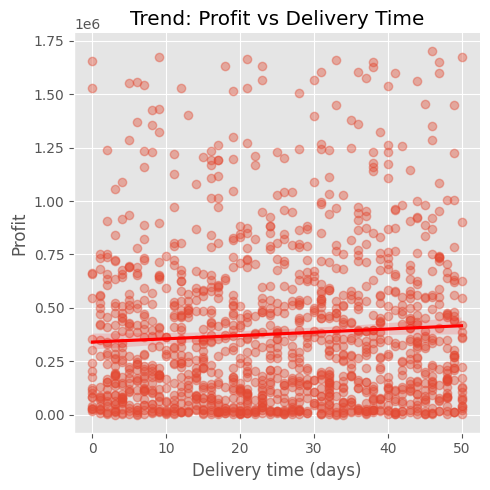

In [ ]:
#Scatter plot: Dependendence between delivery time and profit
plt.figure(figsize=(8, 12))
sns.lmplot(data=df, x="Delivery_Time", y="Profit", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Trend: Profit vs Delivery Time")
plt.xlabel("Delivery time (days)")
plt.ylabel("Profit")
plt.grid(True)
plt.tight_layout()
plt.show()



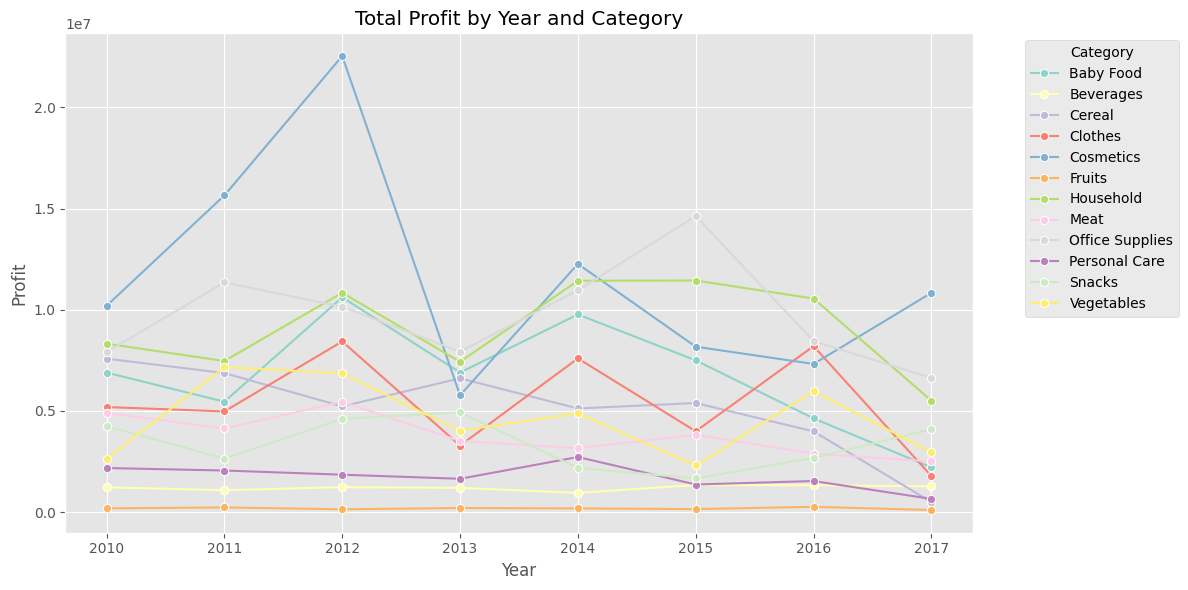

In [ ]:
# Plotting line chart: Total Profit by Year and Category
df["Year"] = df["Order Date"].dt.year

profit_by_category_year = df.groupby(["item_type", "Year"])["Profit"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=profit_by_category_year, x="Year", y="Profit", hue="item_type", marker="o", palette="Set3")

plt.title("Total Profit by Year and Category")
plt.xlabel("Year")
plt.ylabel("Profit")
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

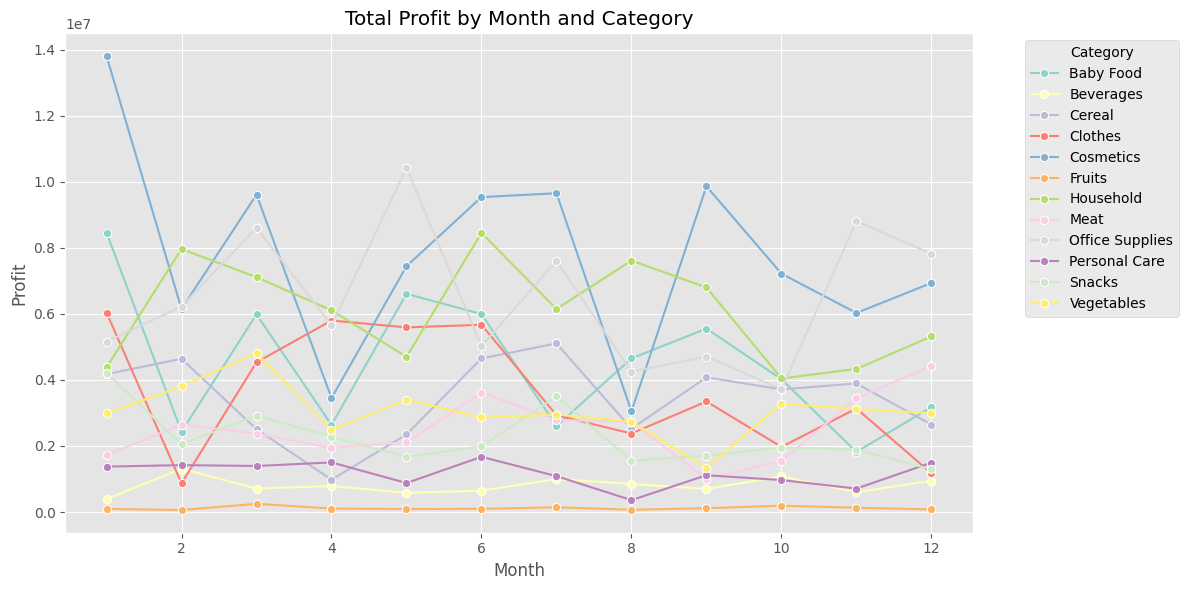

In [ ]:
# Plotting line chart: Total Profit by Month and Category
df["Month"] = df["Order Date"].dt.month
profit_by_category_month = df.groupby(["item_type", "Month"])["Profit"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=profit_by_category_month, x="Month", y="Profit", hue="item_type", marker="o", palette="Set3")

plt.title("Total Profit by Month and Category")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<ipython-input-108-8836d4916114>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_by_category_week_day = df.groupby(["item_type", "Week Day"])["Profit"].sum().reset_index()


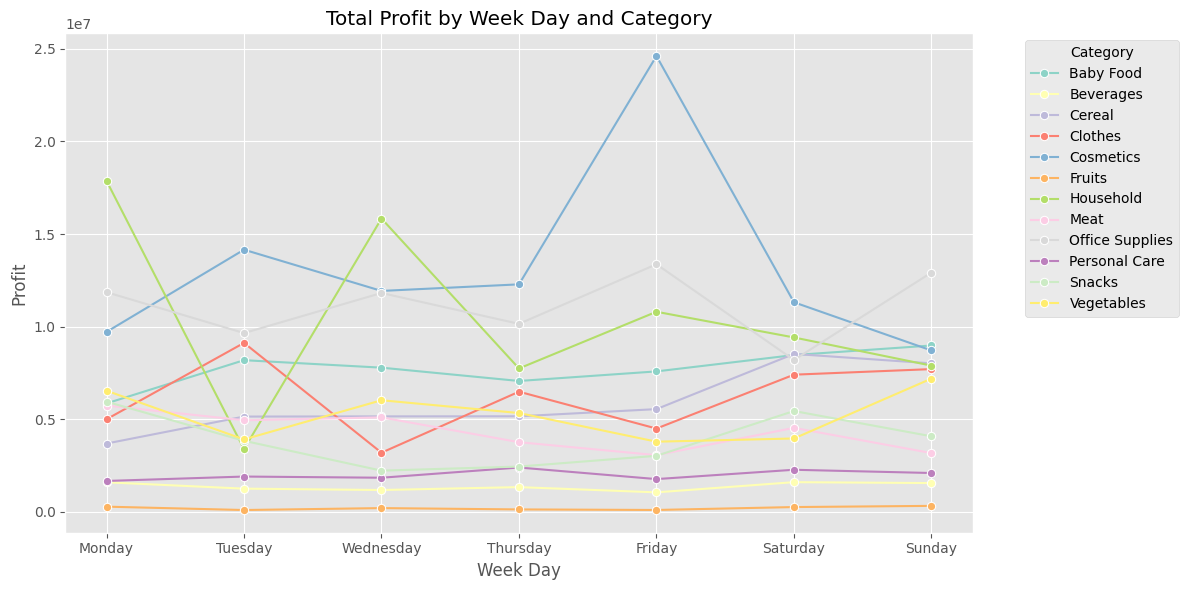

In [ ]:
# Plotting line chart: Total Profit by Week Day and Category

df["Week Day"] = pd.Categorical(
    df["Order Date"].dt.day_name(),
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)

profit_by_category_week_day = df.groupby(["item_type", "Week Day"])["Profit"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=profit_by_category_week_day, x="Week Day", y="Profit", hue="item_type", marker="o", palette="Set3")

plt.title("Total Profit by Week Day and Category")
plt.xlabel("Week Day")
plt.ylabel("Profit")
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Profit dynamics over time

- The largest profit was observed in 2012 due to cosmetics. In 2015, the second largest profit growth was due to sales of office supplies.
- In terms of months, the largest sales are observed in January for most categories. Cosmetics show the largest fluctuations with a maximum of sales in January and minimums in August and April.
- In terms of days of the week, the largest profits are on Friday, especially in the cosmetics category.

